In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv("data/claims_train.csv")
test = pd.read_csv("data/claims_test.csv")

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

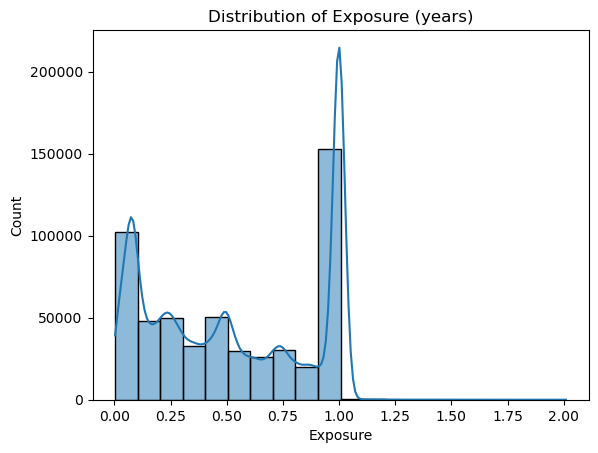

Exposure summary:
 count    542410.000000
mean          0.528840
std           0.364463
min           0.002732
25%           0.180000
50%           0.490000
75%           0.990000
max           2.010000
Name: Exposure, dtype: float64


In [4]:
# --- 1️⃣ Exposure distribution ---
sns.histplot(train['Exposure'], bins=20, kde=True)
plt.title("Distribution of Exposure (years)")
plt.xlabel("Exposure")
plt.ylabel("Count")
plt.show()

exposure_summary = train['Exposure'].describe()
print("Exposure summary:\n", exposure_summary)

In [6]:
# --- Share of policies above 1 year ---
n_total = len(train)
n_above1 = (train['Exposure'] > 1).sum()
share_above1 = n_above1 / n_total * 100
print(f"\nPolicies with Exposure > 1 year: {share_above1:.2f}% ({n_above1} of {n_total})")


Policies with Exposure > 1 year: 0.18% (994 of 542410)


In [8]:
# --- 3️ Claim rate per exposure ---
train['ClaimRate'] = train['ClaimNb'] / train['Exposure']

claim_rate_1yr = train.loc[train['Exposure'] <= 1, 'ClaimRate'].mean()
claim_rate_2yr = train.loc[train['Exposure'] > 1, 'ClaimRate'].mean()

print(f"\nAverage claim rate (≤1 year): {claim_rate_1yr:.4f}")
print(f"Average claim rate (>1 year):  {claim_rate_2yr:.4f}")


Average claim rate (≤1 year): 0.2616
Average claim rate (>1 year):  0.0384


In [9]:
# Remove rows where Exposure > 1 
train = train[train['Exposure'] <= 1].copy()
test = test[test['Exposure'] <= 1].copy()

# --- 3️⃣ Verify ---
print(f"Filtered training data shape: {train.shape}")
print(f"Filtered test data shape: {test.shape}")
print(f"Max exposure after filtering: {train['Exposure'].max()}")


Filtered training data shape: (541416, 13)
Filtered test data shape: (135373, 12)
Max exposure after filtering: 1.0


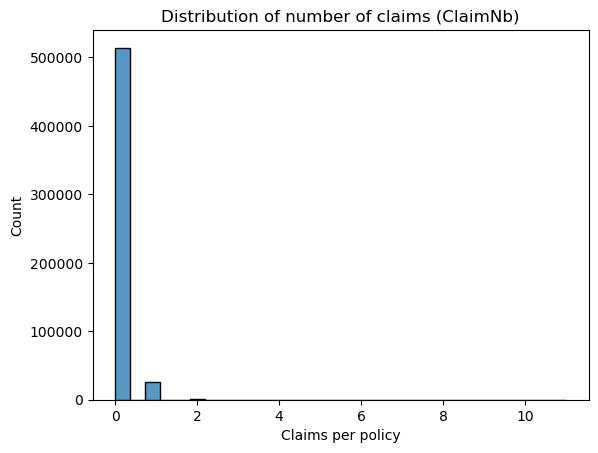

Fraction of policies with 0 claims: 0.9498167767483783
Mean claim count: 0.05314028399604001


In [ ]:
# 1 Target variable analysis ---
sns.histplot(train['ClaimNb'], bins=30, kde=False)
plt.title("Distribution of number of claims (ClaimNb)")
plt.xlabel("Claims per policy")
plt.ylabel("Count")
plt.show()

print("Fraction of policies with 0 claims:", (train['ClaimNb']==0).mean())
print("Mean claim count:", train['ClaimNb'].mean())


A linear regression would completely fail — it assumes a continuous response.

Even a Poisson regression might underestimate the probability of zero claims because the data is more “zero-heavy” than the Poisson distribution allows.

You’ll likely need a Zero-Inflated Poisson (ZIP), Negative Binomial, or Tweedie model to capture this structure.

In [11]:
train['ClaimNb'].var() / train['ClaimNb'].mean()


np.float64(1.0733779822983838)

Implication for modeling:

is much greater than 1 — that’s called overdispersion.

The variance grows faster than the mean → Poisson assumption (Var = Mean) is violated.

Negative Binomial regression handles this by introducing an extra dispersion parameter, reducing bias and improving fit.

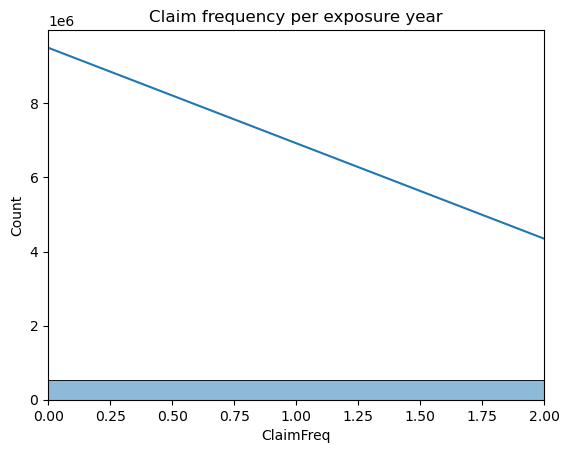

Variance of ClaimFreq: 19.64408385524417
Mean of ClaimFreq: 0.26160079915163226
Variance / Mean ratio: 75.09183427172111


In [12]:

# Claim frequency (per exposure)
train['ClaimFreq'] = train['ClaimNb'] / train['Exposure']
sns.histplot(train['ClaimFreq'], bins=50, kde=True)
plt.title("Claim frequency per exposure year")
plt.xlim(0, 2)
plt.show()

print("Variance of ClaimFreq:", train['ClaimFreq'].var())
print("Mean of ClaimFreq:", train['ClaimFreq'].mean())
print("Variance / Mean ratio:", train['ClaimFreq'].var() / train['ClaimFreq'].mean())
# -> if > 1, overdispersion => Poisson too simple, maybe Negative Binomial

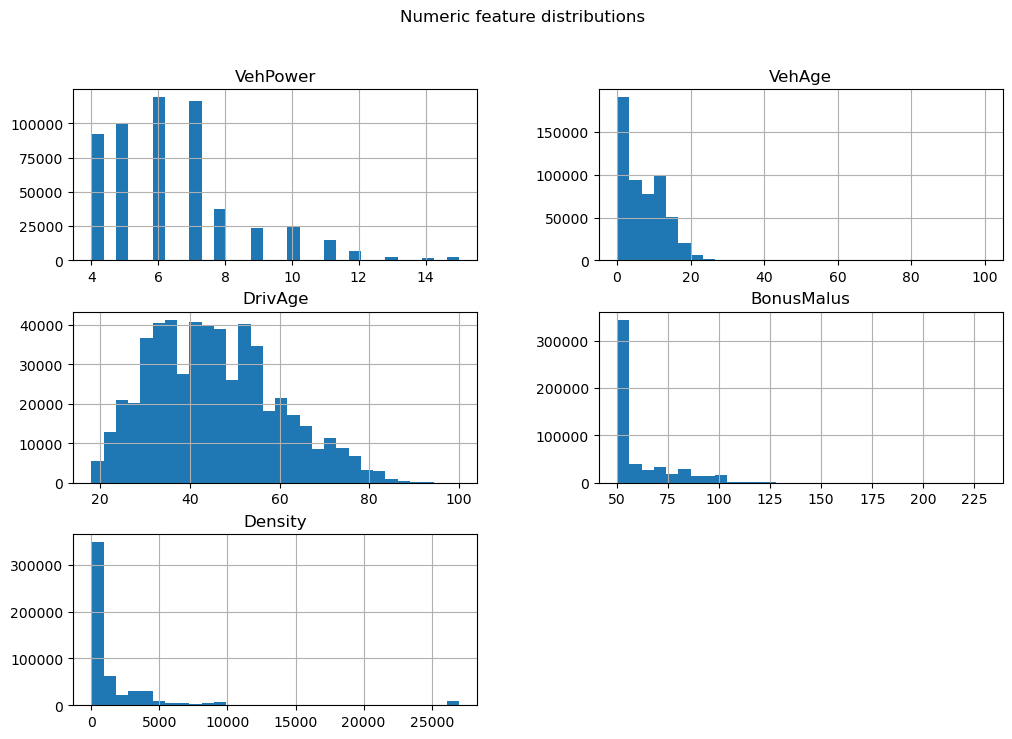

In [14]:
# --- 3️ Numeric feature distributions ---
num_cols = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']
train[num_cols].hist(bins=30, figsize=(12,8))
plt.suptitle("Numeric feature distributions")
plt.show()


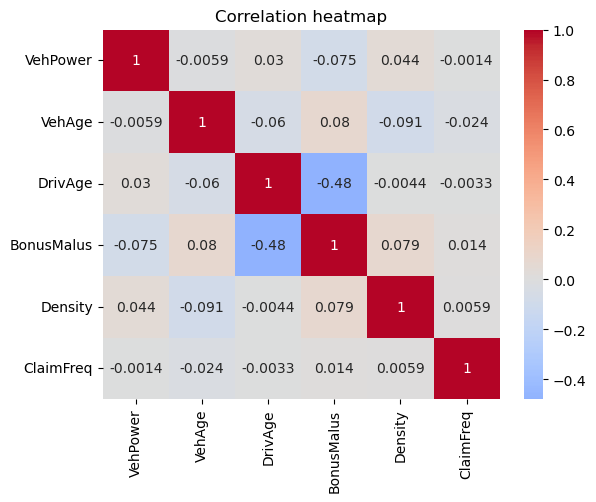

In [15]:
# --- 4️ Correlations among numeric features ---
corr = train[num_cols + ['ClaimFreq']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation heatmap")
plt.show()

we dont have multicolineraity - so good, but linear model will be biased, will over/under estimate each time 